# Data exploration

Data exploration of ADNI patients. The data consists of features derived from T1 weighted images of patients in their first MRI visit in each phase of the program. The features were extracted using SIENAX to determine tissue types and FIRST to determine subcortical structure volumes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Data merging

In [2]:
def process_df(phase):
    # Load data
    df_features = pd.read_table('../DATA/processed_data_adni%d.tsv'%phase, sep=' ').dropna()
    df_patient_list = pd.read_table('../DATA/participants_adni%d.tsv'%phase, names=['Subject', 'PTID'])
    df_metadata = pd.read_csv('../DATA/adni%d_mri.csv'%phase, index_col=0)
    
    # Combine left and right structures to single structure
    structures = ['Thalmus', 'Caudate', 'Putamen', 'Palidum', 
            'Hippo', 'Amygdala', 'Accumbens']
    for s in structures:
        df_features[s] = df_features['L_%s'%s]+df_features['R_%s'%s]
    
    df_full = df_patient_list.merge(df_features, on='Subject').merge(df_metadata, on='PTID')
                                                                 
    # Remove sites that do not contain alzeihmers patient
    all_sites = set(df_full['SITEID'])
    ad_sites = set(df_full[df_full['DIAGNOSIS']==3.0]['SITEID'])
    missing_sites = [site for site in all_sites if site not in ad_sites]
    df_full = df_full[df_full['SITEID'].isin(missing_sites) == False]
    
    # Get back non-normalized (raw features)
    for f in ['Brain_norm', 'GM_norm', 'WM_norm',
        'vscf_norm', 'pgrey_norm']:
        df_full[f] = df_full[f]/df_full['Vscale']

    # Change gender and phase assigment
    df_full['PTGENDER'].replace(['Female','Male'],[0,1],inplace=True)
    df_full['Phase'].replace(['ADNI2','ADNI3'],[0,1],inplace=True)

    return df_full

# Create dataframes for each phase
df_full_adni2 = process_df(2)
df_full_adni3 = process_df(3)

# Concatenate dataframes
pd.set_option('display.max_columns', None)
df_full = pd.concat([df_full_adni2, df_full_adni3], ignore_index=True)
df_full = df_full.drop_duplicates('RID', keep='first') # keep ADNI2 if duplciates

### Site analysis

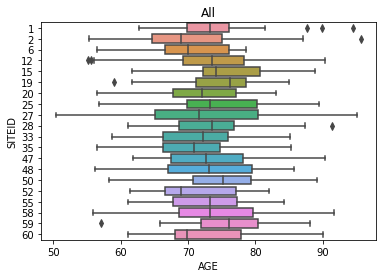

In [3]:
# Show age distribution by site
plt.figure()
plt.title('All')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full, orient='h')
plt.show()

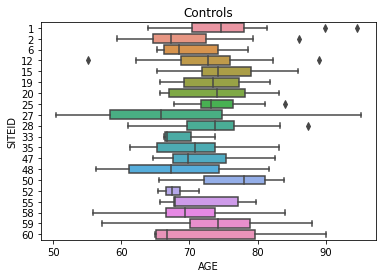

In [4]:
# Show age distribution by site
plt.figure()
plt.title('Controls')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==1.0], orient='h')
plt.show()

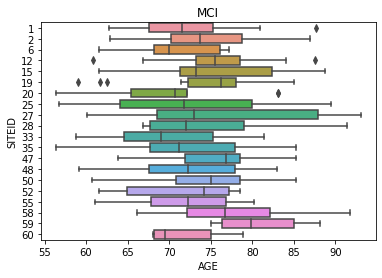

In [5]:
# Show age distribution by site
plt.figure()
plt.title('MCI')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==2.0], orient='h')
plt.show()

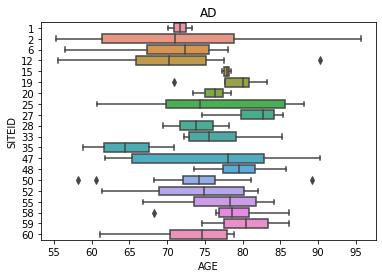

In [6]:
# Show age distribution by site
plt.figure()
plt.title('AD')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==3.0], orient='h')
plt.show()

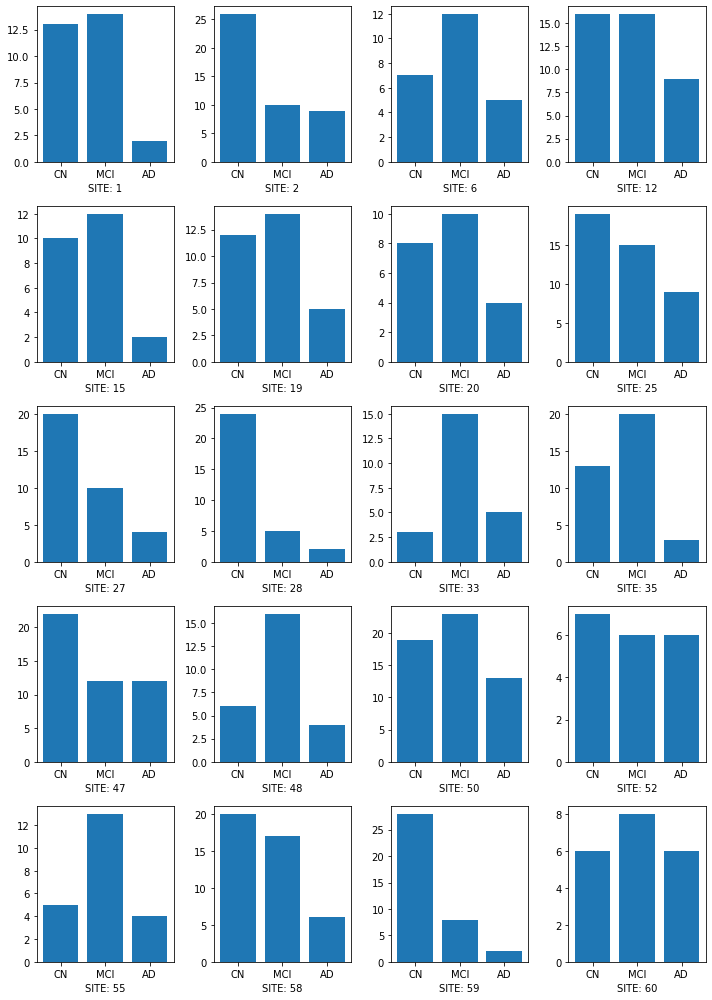

In [7]:
plt.figure(figsize=(10,14))
names = ['CN', 'MCI', 'AD']
sites = set(df_full['SITEID'])
for i, site in enumerate(sites):
    # Explor variability of features by site
    plt.subplot(5,4,i+1)
    df_site = df_full[df_full['SITEID']==site]
    vals = [np.sum(df_site['DIAGNOSIS']==diag) for diag in [1.0, 2.0, 3.0]]
    plt.bar(names, vals)
    plt.xlabel('SITE: %d' %site)
    plt.tight_layout()

### Analysis on control

In [8]:
# Exctract controls
df_controls = df_full[df_full['DIAGNOSIS']==1.0]

# Mark features to use
features = ['Brain_norm', 'GM_norm', 'WM_norm',
        'vscf_norm', 'pgrey_norm', 'Thalmus', 'Caudate', 'Putamen', 'Palidum', 
        'Hippo', 'Amygdala', 'Accumbens', 'Brainstem']

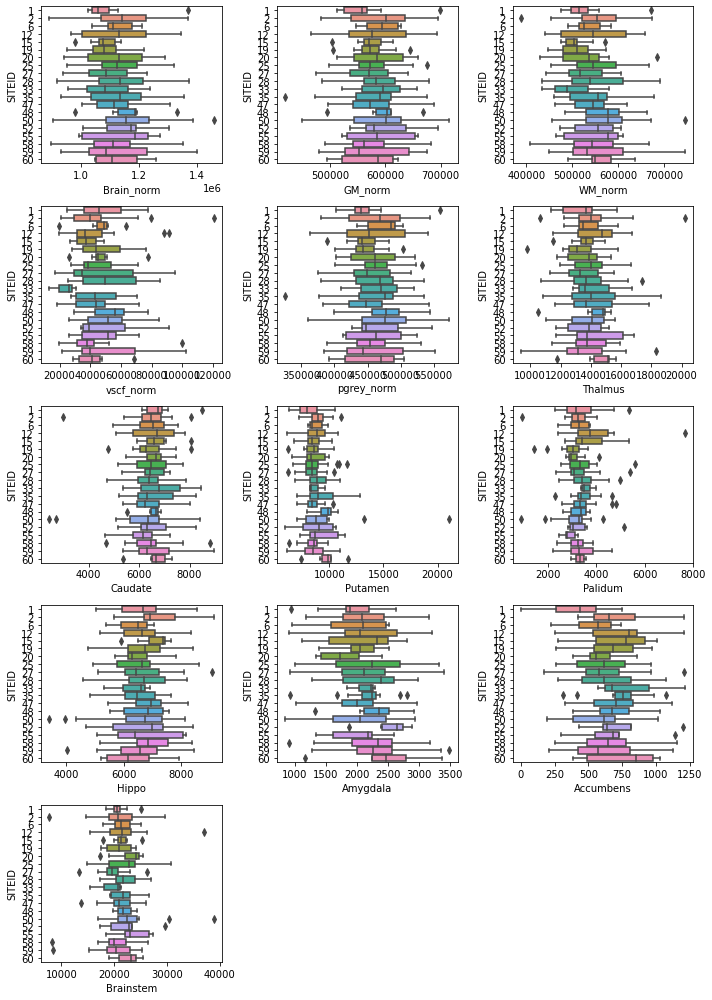

In [9]:
# Explor variability of features by site
plt.figure(figsize=(10,14))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    ax = sns.boxplot(x=feature, y='SITEID', data=df_controls, orient='h')
    plt.tight_layout()

In [10]:
# Data harmonization with Combat
from pycombat import Combat
combat = Combat()
Y = df_controls[features].to_numpy()
b = df_controls['SITEID'].to_numpy()
X = df_controls['AGE'].to_numpy()[:, np.newaxis]
C = df_controls[['Vscale', 'PTGENDER', 'Phase']].to_numpy()
y_adjusted = combat.fit_transform(Y=Y, b=b, X=X, C=C)

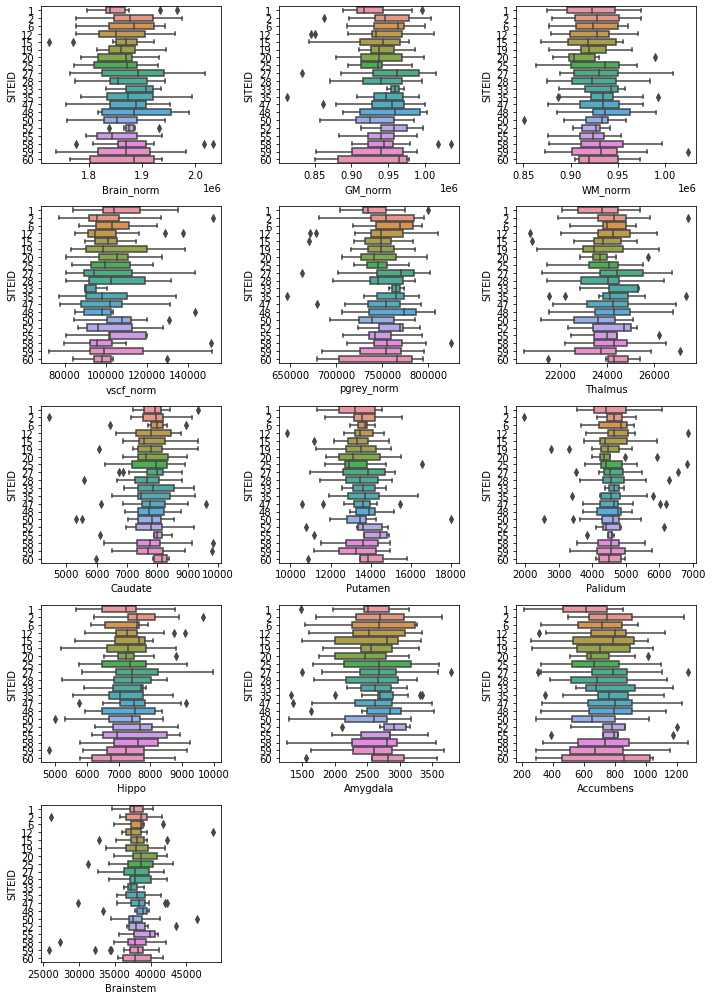

In [11]:
# Explor variability of features by site after harmonization
df_features_harm = pd.DataFrame(data=y_adjusted, columns=features)
df_features_harm['SITEID'] = df_controls['SITEID'].reset_index(drop=True)
plt.figure(figsize=(10,14))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    ax = sns.boxplot(x=feature, y='SITEID', data=df_features_harm, orient='h')
    plt.tight_layout()

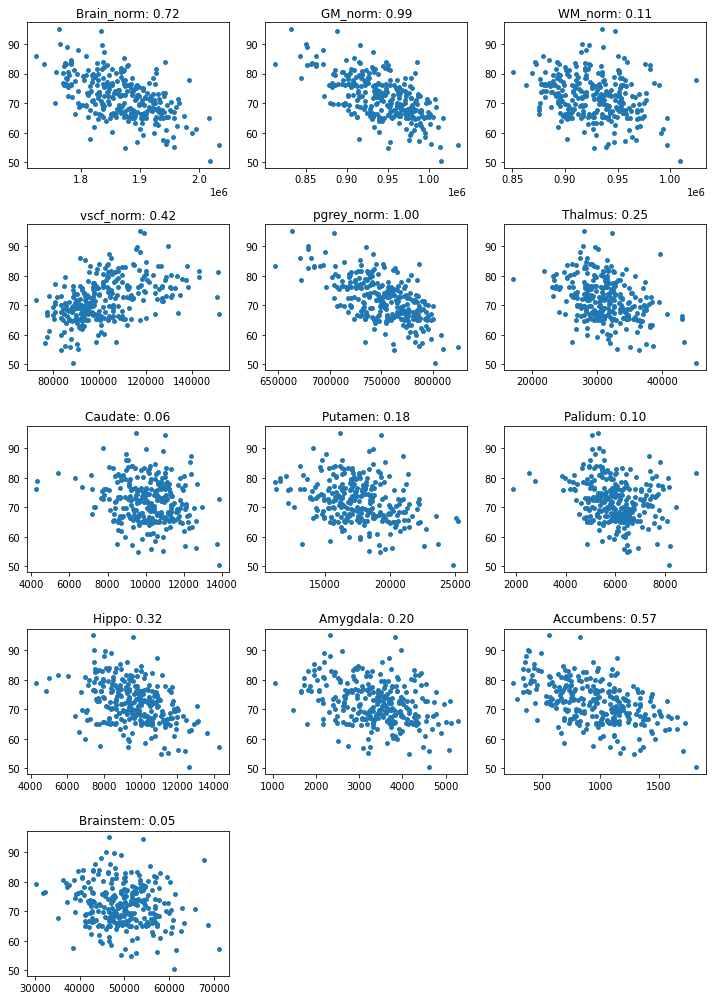

In [12]:
from sklearn.feature_selection import f_regression

X = df_features_harm[features].to_numpy()
Y = df_controls['AGE'].to_numpy()
# Normalize subcortical features by size of brain
vscale = df_controls['Vscale'].to_numpy()
X[:, 5:] = X[:, 5:]*vscale[:, None]

f_test, _ = f_regression(X, Y)
f_test /= np.max(f_test) # We normalize beacuse we are interested in relative values

plt.figure(figsize=(10,14))
for d in range (len(features)):
    plt.subplot(5,3,d+1)
    plt.scatter(X[:,d],Y,s=15)
    plt.title("{0}: {1:.2f}".format(features[d],f_test[d]))
plt.tight_layout()

In [13]:
# Generate train and test partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0)

# Data normalization
transformer = StandardScaler().fit(X_train)  # fit() learns mean and std parameters
X_train_norm = transformer.transform(X_train) # transform() normalizes
X_test_norm =  transformer.transform(X_test)

MAE in test: 4.040801


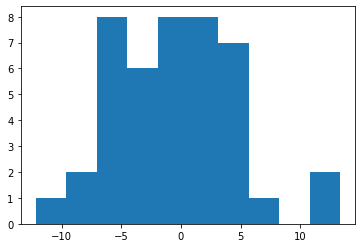

In [14]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression(fit_intercept='True')
# Train the model
LR.fit(X_train, Y_train)

# Compute the predictions over test data
f_test = LR.predict(X_test)
errors = Y_test-f_test
MAE_test = np.mean(np.abs(errors))
print('MAE in test: %f' % MAE_test)
plt.hist(errors)
plt.show()

### TODO

Create cross validation skeam y mirar lasso, ridge, y polynomial
Probar random forests

### Brain delta in MCI and AD

Brain delta mean for
CN: -0.464470
MCI: 3.266148
AD: 7.090086
Brain delta median for
CN: -0.352011
MCI: 3.176477
AD: 6.980765


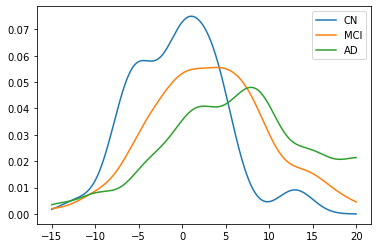

In [15]:
# Obtain dataframes for each diagnosis
df_mci = df_full[df_full['DIAGNOSIS']==2.0]
df_ad = df_full[df_full['DIAGNOSIS']==3.0]

# Set data for processing
X_mci = df_mci[features].to_numpy()
Y_mci = df_mci['AGE'].to_numpy()
b_mci = df_mci['SITEID'].to_numpy()
C_mci = df_mci[['Vscale', 'PTGENDER', 'Phase']].to_numpy()
X_ad = df_ad[features].to_numpy()
Y_ad = df_ad['AGE'].to_numpy()
b_ad = df_ad['SITEID'].to_numpy()
C_ad = df_ad[['Vscale', 'PTGENDER', 'Phase']].to_numpy()

# Harmonize
X_mci_harm = combat.transform(Y=X_mci, b=b_mci, X=Y_mci[:, np.newaxis], C=C_mci)
X_ad_harm = combat.transform(Y=X_ad, b=b_ad, X=Y_ad[:, np.newaxis], C=C_ad)

# Make estimations
delta_brain_controls = errors
delta_brain_mci = LR.predict(X_mci_harm)-Y_mci
delta_brain_ad = LR.predict(X_ad_harm)-Y_ad

# Obtain mean and medians for each
print('Brain delta mean for')
print('CN: %f' % np.mean(delta_brain_controls))
print('MCI: %f' % np.mean(delta_brain_mci))
print('AD: %f' % np.mean(delta_brain_ad))
print('Brain delta median for')
print('CN: %f' % np.median(delta_brain_controls))
print('MCI: %f' % np.median(delta_brain_mci))
print('AD: %f' % np.median(delta_brain_ad))

# Plot kernel density estimates for samples
from sklearn.neighbors import KernelDensity
X_plot = np.linspace(-15, 20, 1000)[:, np.newaxis]
kde_cn = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_controls[:, np.newaxis])
log_dens_cn = kde_cn.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_cn), label='CN')
kde_mci = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
kde_ad = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_ad[:, np.newaxis])
log_dens_ad = kde_ad.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='AD')
plt.legend()
plt.show()

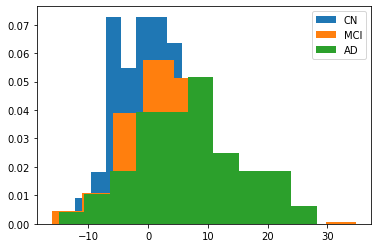

In [16]:
plt.hist(delta_brain_controls, label='CN', density=True)
plt.hist(delta_brain_mci, label='MCI', density=True)
plt.hist(delta_brain_ad, label='AD', density=True)
plt.legend()
plt.show()

In [17]:
# TODO mirar conversor donde cae